# Initialize all imports

In [1]:
import os
import conda_installer
import pandas as pd
import tensorflow as tf
import numpy as np
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import copy
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import importlib
import keras.backend as K
# import tensorflow_addons as tfa
from tensorflow.keras import regularizers, constraints, callbacks

import sys
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam


2025-04-30 21:29:13.555919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 21:29:13.622861: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normaliz

In [2]:
PDBs = pickle.load(open('Datasets/PDBs_RDKit.pkl', 'rb'))
df = pd.read_csv('Datasets/T_data.csv')

In [3]:
df.head()

,Unnamed: 0,Id,TS_comp,TS_host,TS_ligand,exp
0,0,gilson_cb7--guest1,219.726160,170.780918,32.569296,-0.9
1,1,gilson_cb7--guest2,243.211795,170.780918,54.026506,-0.4
2,2,gilson_cb7--guest3,228.890715,170.780918,41.655571,-0.1
3,3,gilson_cb7--guest4,203.927320,170.780918,19.589363,0.6
4,4,gilson_cb7--guest5,266.219403,170.780918,80.367673,0.0


In [4]:

len(PDBs)

103

In [5]:
info = []
for pdb in list(PDBs.keys()):
    info.append(df[df['Id'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])

In [6]:
from models.dcFeaturizer import atom_features as get_atom_features
def featurize(molecule, info):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum(),atom.GetFormalCharge()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]

        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)

In [7]:
X = []
y = []
for i, pdb in enumerate(list(PDBs.keys())):
    X.append(featurize(PDBs[pdb], info[i]))
    y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])

In [8]:
# Split the data into training and testing sets
# Randomly shuffles the data before splitting, ensuring that the training and testing sets are representative of the overall dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)


In [9]:
len(X_train), len(X_test), len(y_train), len(y_test)

(82, 21, 82, 21)

In [10]:
X_train[1].shape

(89, 41)

# Helper Functions

In [11]:
import models.layers_update_mobley as layers
from models.dcFeaturizer import atom_features as get_atom_features
importlib.reload(layers)

<module 'models.layers_update_mobley' from '/home/lthoma21/BFE-Loss-Function/FINAL-HOSTGUEST-FILES/models/layers_update_mobley.py'>

In [12]:
class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features=36, r_out_channel=20, c_out_channel=128, l2=1e-4, dropout_rate=0.2, maxnorm=3.0):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel, r_out_channel)
        self.dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense5 = tf.keras.layers.Dense(16, activation='relu', name='dense2', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense6 = tf.keras.layers.Dense(1, name='dense6', kernel_regularizer=regularizers.l2(l2), bias_regularizer=regularizers.l2(l2), kernel_constraint=constraints.MaxNorm(maxnorm))
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                                             kernel_initializer=tf.keras.initializers.Constant([-.3, -1, 1, 1]),
                                             bias_initializer=tf.keras.initializers.Zeros(),
                                             kernel_regularizer=regularizers.l2(l2), 
                                             bias_regularizer=regularizers.l2(l2), 
                                             kernel_constraint=constraints.MaxNorm(maxnorm))
        self.all_layer_1_weights = []

    def addRule(self, rule, start_index, end_index=None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
        
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs, training=False):
        print("Inside call")
        physics_info = inputs[:, 0, 38:] 
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense5(x)
        x = self.dropout2(x, training=training)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        out = self.dense7(merged)
        return tf.concat([out, physics_info], axis=1)
    
class LossComponentsCallback(tf.keras.callbacks.Callback):
    def __init__(self,model_instance):
        super().__init__()
        self.empirical_losses = []
        self.physical_losses = []
        self.total_losses = []
        self.learning_rates = []
        self.model = model_instance
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Store the total loss
        self.total_losses.append(logs.get('loss'))
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)  # Call the schedule
        else:
            lr = lr  

        self.learning_rates.append(float(tf.keras.backend.get_value(lr)))


def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred[0] - y_true))) + K.abs(1 / K.mean(.2 + y_pred[1]))


def pure_rmse(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    return K.sqrt(K.mean(K.square(y_pred - y_true_flat)))

def physical_consistency_loss(y_true,y_pred,physics_info):
    dS_pred = y_pred
    y_true = tf.reshape(y_true, (-1, 1))

    # Physical Inconsistency loss
    # Extract the components from physics_info
    host = tf.gather(physics_info, [1], axis=1)  # Host energy terms
    guest = tf.gather(physics_info, [2], axis=1)  # Guest energy terms
    complex_ = tf.gather(physics_info, [0], axis=1)  # Complex energy terms
    
#     tf.print("Host:", host)
#     tf.print("Guest:", guest)
#     tf.print("Complex:", complex_)

    # Calculate ΔG based on physics: ΔS = ΔScomplex - (ΔShost + ΔSguest)
    dS_physics = -tf.reduce_sum(complex_, axis=1, keepdims=True) + tf.reduce_sum(host, axis=1, keepdims=True) + tf.reduce_sum(guest, axis=1, keepdims=True)
    phy_loss = K.sqrt(K.mean(K.square(dS_pred - dS_physics)))
#     tf.print("DS_pred",dS_pred)
#     tf.print("DS_physics",dS_physics)

    return phy_loss



def combined_loss(physics_hyperparam=0.0003):
    def loss_function(y_true, y_pred):
        # Extract prediction and physics info
        prediction = y_pred[:, 0]
        physics_info = y_pred[:, 1:4]  # Assuming 15 physical features
        
        # Calculate individual loss components
        empirical_loss = pure_rmse(y_true, prediction)
        physics_loss = physical_consistency_loss(y_true, prediction, physics_info)
        
        # Combine losses with weights
        total_loss = empirical_loss + (physics_hyperparam * physics_loss)
        
        return total_loss
    
    return loss_function

---------- Hyperparameter combinations ------------
Epoch : 500;  physics_weight: 0.005;
Epoch 1/500


2025-04-30 21:29:23.029204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-30 21:29:23.029239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (curie.cluster): /proc/driver/nvidia/version does not exist
2025-04-30 21:29:23.029982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Inside call
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Inside call
1/1 [==============================] - 78s 78s/step - loss: 12.9264
Epoch 2/500
1/1 [==============================] - 1s 1s/step - loss: 10.8080
Epoch 3/500
1/1 [==============================] - 1s 801ms/step - loss: 8.7518
Epoch 4/500
1/1 [==============================] - 1s 1s/step - loss: 6.8096
Epoch 5/500
1/1 [==============================] - 1s 1s/step - loss: 5.1112
Epoch 6/500
1/1 [==============================] - 1s 1s/step - loss: 3.9768
Epoch 7/500
1/1 [==============================] - 1s 1s/step - loss: 3.8597
Epoch 8/500
1/1 [==============================] - 1s 1s/step - loss: 4.5149
Epoch 9/500
1/1 [==============================] - 1s 1s/step - loss: 5.2089
Epoch 10/500
1/1 [==============================] - 1s 1s/step - loss: 5.6235
Epoch 11/

1/1 [==============================] - 1s 1s/step - loss: 3.7052
Epoch 100/500
1/1 [==============================] - 1s 1s/step - loss: 3.7049
Epoch 101/500
1/1 [==============================] - 1s 1s/step - loss: 3.7046
Epoch 102/500
1/1 [==============================] - 1s 1s/step - loss: 3.7041
Epoch 103/500
1/1 [==============================] - 1s 1s/step - loss: 3.7036
Epoch 104/500
1/1 [==============================] - 1s 1s/step - loss: 3.7031
Epoch 105/500
1/1 [==============================] - 1s 1s/step - loss: 3.7026
Epoch 106/500
1/1 [==============================] - 1s 1s/step - loss: 3.7022
Epoch 107/500
1/1 [==============================] - 1s 1s/step - loss: 3.7018
Epoch 108/500
1/1 [==============================] - 1s 1s/step - loss: 3.7014
Epoch 109/500
1/1 [==============================] - 1s 1s/step - loss: 3.7009
Epoch 110/500
1/1 [==============================] - 1s 1s/step - loss: 3.7004
Epoch 111/500
1/1 [==============================] - 1s 1s/step - 

1/1 [==============================] - 1s 1s/step - loss: 3.6367
Epoch 203/500
1/1 [==============================] - 1s 1s/step - loss: 3.6357
Epoch 204/500
1/1 [==============================] - 1s 1s/step - loss: 3.6346
Epoch 205/500
1/1 [==============================] - 1s 1s/step - loss: 3.6336
Epoch 206/500
1/1 [==============================] - 1s 1s/step - loss: 3.6325
Epoch 207/500
1/1 [==============================] - 1s 1s/step - loss: 3.6315
Epoch 208/500
1/1 [==============================] - 1s 1s/step - loss: 3.6304
Epoch 209/500
1/1 [==============================] - 1s 1s/step - loss: 3.6293
Epoch 210/500
1/1 [==============================] - 1s 1s/step - loss: 3.6282
Epoch 211/500
1/1 [==============================] - 1s 1s/step - loss: 3.6271
Epoch 212/500
1/1 [==============================] - 1s 1s/step - loss: 3.6260
Epoch 213/500
1/1 [==============================] - 1s 1s/step - loss: 3.6249
Epoch 214/500
1/1 [==============================] - 1s 1s/step - 

1/1 [==============================] - 1s 1s/step - loss: 3.4746
Epoch 306/500
1/1 [==============================] - 1s 1s/step - loss: 3.4724
Epoch 307/500
1/1 [==============================] - 1s 1s/step - loss: 3.4703
Epoch 308/500
1/1 [==============================] - 1s 1s/step - loss: 3.4682
Epoch 309/500
1/1 [==============================] - 1s 1s/step - loss: 3.4660
Epoch 310/500
1/1 [==============================] - 1s 1s/step - loss: 3.4639
Epoch 311/500
1/1 [==============================] - 1s 1s/step - loss: 3.4617
Epoch 312/500
1/1 [==============================] - 1s 1s/step - loss: 3.4595
Epoch 313/500
1/1 [==============================] - 1s 1s/step - loss: 3.4573
Epoch 314/500
1/1 [==============================] - 1s 1s/step - loss: 3.4551
Epoch 315/500
1/1 [==============================] - 1s 1s/step - loss: 3.4529
Epoch 316/500
1/1 [==============================] - 1s 1s/step - loss: 3.4507
Epoch 317/500
1/1 [==============================] - 1s 1s/step - 

1/1 [==============================] - 1s 1s/step - loss: 2.9465
Epoch 409/500
1/1 [==============================] - 1s 1s/step - loss: 2.9400
Epoch 410/500
1/1 [==============================] - 1s 1s/step - loss: 2.9337
Epoch 411/500
1/1 [==============================] - 1s 1s/step - loss: 2.9273
Epoch 412/500
1/1 [==============================] - 1s 1s/step - loss: 2.9210
Epoch 413/500
1/1 [==============================] - 1s 1s/step - loss: 2.9148
Epoch 414/500
1/1 [==============================] - 1s 1s/step - loss: 2.9086
Epoch 415/500
1/1 [==============================] - 1s 1s/step - loss: 2.9024
Epoch 416/500
1/1 [==============================] - 1s 1s/step - loss: 2.8963
Epoch 417/500
1/1 [==============================] - 1s 1s/step - loss: 2.8902
Epoch 418/500
1/1 [==============================] - 1s 1s/step - loss: 2.8841
Epoch 419/500
1/1 [==============================] - 1s 1s/step - loss: 2.8781
Epoch 420/500
1/1 [==============================] - 1s 1s/step - 

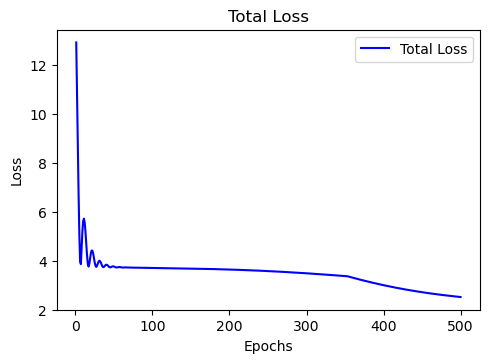

In [13]:
import csv

physics_hyperparam = [0.005]
epochs = [500]
lr_schedule = ExponentialDecay(
        initial_learning_rate=0.005,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True
    )

y_differences = []
total_losses = []
empirical_losses = []
physics_losses = []
all_results=[]
    
for epoch in epochs:
        for physics_weight in physics_hyperparam:
            print("---------- Hyperparameter combinations ------------")
            print("Epoch : {};  physics_weight: {};".format(str(epoch),  str(physics_weight)))

            m = PGGCNModel()
            m.addRule("sum", 0, 32)
            m.addRule("multiply", 32, 33)
            m.addRule("distance", 33, 36)

            opt = tf.keras.optimizers.Adam(learning_rate=0.005)
            m.compile(loss=combined_loss(physics_weight), optimizer=opt)

            input_shapes = []
            for i in range(len(X_train)):
                input_shapes.append(np.array(X_train[i]).shape[0])
            m.set_input_shapes(input_shapes)
            for i in range(len(X_train)):
                if X_train[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_train[i].shape[0], 41])
                    X_train[i] = np.concatenate([X_train[i], new_list], 0)
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            

            loss_tracker = LossComponentsCallback(m)

            # Add early stopping
            early_stopping = EarlyStopping(
                monitor='loss',           
                patience=10,              
                restore_best_weights=True, 
                min_delta=0.001,          
                verbose=1                 
            )

            hist = m.fit(X_train, y_train, epochs = epoch, batch_size=len(X_train),callbacks=[early_stopping,loss_tracker])


            input_shapes = []
            for i in range(len(X_test)):
                input_shapes.append(np.array(X_test[i]).shape[0])
            m.set_input_shapes(input_shapes)

            for i in range(len(X_test)):
                if X_test[i].shape[0] < 2000:
                    new_list = np.zeros([2000 - X_test[i].shape[0], 41])
                    X_test[i] = np.concatenate([X_test[i], new_list], 0)
            X_test = np.array(X_test)
            x_c = copy.deepcopy(X_test)
            y_test = np.array(y_test)
            y_pred_test = m.predict(X_test)
            y_pred_test = np.array(y_pred_test[:,0])

            y_difference = np.mean(np.abs(np.abs(y_test) - np.abs(y_pred_test)))
            eval = m.evaluate(X_test, y_test)
            print("The mean absolute difference between y_tru & y_pred is : {}" .format(str(y_difference)))

            final_train_loss = loss_tracker.total_losses[-1] if loss_tracker.total_losses else None
            
        # Plot all loss components over epochs
        plt.figure(figsize=(12, 8))

        epoch_length = range(1, len(loss_tracker.total_losses) + 1)

        # Total loss
        plt.subplot(2, 2, 1)
        plt.plot(epoch_length, loss_tracker.total_losses, 'b-', label='Total Loss')
        plt.title('Total Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
            

#     # Learning rate
#     plt.subplot(2, 2, 2)
#     plt.plot(epochs, loss_tracker.learning_rates, 'g-', label='Learning Rate')
#     plt.title('Learning Rate')
#     plt.xlabel('Epochs')
#     plt.ylabel('Learning Rate')
#     plt.legend()

#     plt.tight_layout()
#     plt.savefig('loss_components.png')
#     plt.show()